# Response Time: Some Statistics
This is a notebook that explores response time of the tweets.
For questions, contact Alicia.

## Set-up:
### Imports:
Firth the necessary packages are imported:

In [1]:
# IMPORTS
import sys
sys.path.append("../DBL-Data-Challenge")

# Own functions
from database.connect import getConnection
from notebooks.response2 import response_time_id, response_time_calc, mentions, length, mention_count
import matplotlib.pyplot as plt


# Packages
import pandas as pd
import seaborn as sns
import matplotlib as plt
sns.set()

Then a connection to a MySQL database is set up.

In [2]:
# Get connection
try:
    connection = getConnection()
except Exception:
    print("✖️ Error while connecting to MySQL engine database.")
    print("ℹ️ Please make sure the environment file `.env` is located at"+
        "the project root directory and contains proper configuration.")
    raise

### Creating the datafrane:
All the relevant data is fetched from the table. A list is used to keep track of the index of the columns.

In [3]:
# query relevant data and fetch it
cursor = connection.cursor()
query_columns = ['id', 'text', 'in_reply_to_status_id', 'timestamp_ms', 'mentions', 'user_id', 'sentiment']
query="SELECT id, text, in_reply_to_status_id, timestamp_ms, mentions, user_id, sentiment FROM tweets"
cursor.execute(query)
tweets = cursor.fetchall()

A Pandas dataframe is created from this data, with the relevant columns for the analysis. The necessary functions are imported from response2.py

In [4]:
"""Creating the dataframe
    :columns: [response_time, tweet_sentiment, mentions, tweet_length]
    :values: [int (ms), float in range(-1, 1), list(str), int]
"""

# Creating the dataframe
upper_limit = 1000

df_columns = ['response_time', 'tweet_sentiment', 'mentions', 'tweet_length']
df_data = pd.DataFrame(columns=df_columns)

# Read data from tweets with desired limit
for tuple in tweets[0:upper_limit]:  
    dict = {'response_time': 'Null', 'tweet_sentiment': 'Null', 'mention_count': 'Null', 'airline': 'Null', 'tweet_length': 'Null'}
        
    # Response time -> int, unit: ms
    try:
        dict['response_time'] = response_time_id(tuple[query_columns.index('id')], cursor) 
    except Exception:
        pass   

    # Sentiment detection -> float, in range(-1, 1)
    try:
        dict['tweet_sentiment'] = float(tuple[query_columns.index('sentiment')])
    except Exception:
        pass
    
    # User mentions -> list(str, str, ...)
    try:
        dict['mentions'] = mentions(tuple[query_columns.index('mentions')])
    except Exception:
        pass
    
     # Airline -> str
    try:
        dict['airline'] = mentions(tuple[query_columns.index('airline')])
    except Exception:
        pass   

    # Tweet length -> int
    try:    
        dict['tweet_length'] = length(tuple[query_columns.index('text')])
    except Exception:
        pass

    # Add to dataframe
    df_dict = pd.DataFrame([dict])
    df_data = pd.concat([df_data, df_dict], ignore_index=True)

# Close connection
cursor.close()
connection.close()

df_data.head()

,response_time,tweet_sentiment,mentions,tweet_length
0,no_reply,-0.462126,"[no_airline, no_airline, no_airline]",140
1,no_reply,0.164795,[BritishAirways],16
2,no_reply,0.929742,"[no_airline, AmericanAir, no_airline]",140
3,no_reply,0.043662,"[no_airline, no_airline, no_airline]",140
4,no_reply,-0.630411,[],77


Since the value of most reponse times are "no_reply" and thus unlikely to see another value in the head, a double check is needed to see if everything was added correctly. 

In [5]:
# Check if the response time was added successfully
for i in range(0, len(df_data.index)):
    if df_data.loc[i, 'response_time'] != 'no_reply':
        print('Successfully added')
        print(f"example: {df_data.loc[i, 'response_time']}")
        break


Successfully added
example: 0.039820555555555553


## Statistics and Plots
First we give some basic statistics.

In [6]:
# Response time basic statistics
df_data['response_time'].describe(include='all')

count         1000
unique         158
top       no_reply
freq           843
Name: response_time, dtype: object

### Reply-rate boxplot:

In [7]:
no_reply_count = df_data['response_time'].value_counts()['no_reply']
reply_count = len(df_data.index) - no_reply_count

df_reply_rate = pd.DataFrame([{'reply_count': reply_count, 'no_reply_count': no_reply_count}])
df_reply_rate.head()

,reply_count,no_reply_count
0,157,843


Text(0, 0.5, 'Percentage [%]')

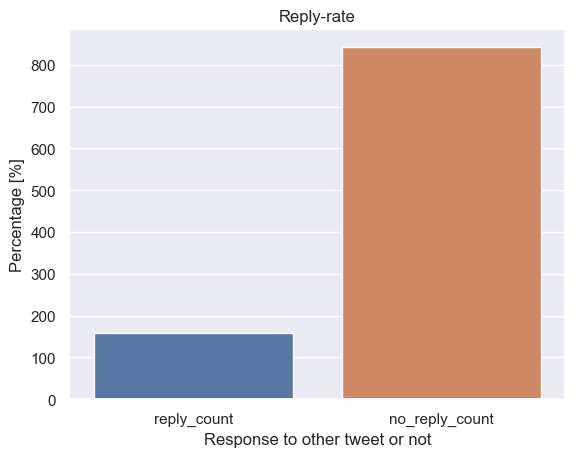

In [8]:
ax = sns.barplot(df_reply_rate)
ax.set_title("Reply-rate")
ax.set_xlabel('Response to other tweet or not')
ax.set_ylabel('Percentage [%]')

### Boxplot of reply time per competitor airplanes and in general.

In [ ]:
df_user = 0


df_user_time_clean = pd.DataFrame()

for i in range(0, len(df_user.index)):
    if df_user.loc[i, 'response_time'] != 0:
        dict = {'response_time': (df_user.loc[i, 'response_time'])/(1000*60*60), 'airline': df_user.loc[i, 'airline']}
        df_dict = pd.DataFrame([dict])
        df_user_time_clean = pd.concat([df_user_time_clean, df_dict], ignore_index=True)
        
df_user_time_clean.head()


In [ ]:
ax = sns.boxplot(data=df_user_time_clean, x='airline', y='response_time', showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('Airlines')
ax.set_ylabel('Reply time (hours)')
ax.set_title('Boxplot of reply time per airline');